In [1]:
import sys
import time
import os.path
from glob import glob
from datetime import datetime, timedelta

# data tools
import h5py
import numpy as np
import pandas as pd

# custom tools
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/Analog_BC/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/Analog_BC/utils/')

import data_utils as du
import graph_utils as gu

from namelist import *

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# graph tools
import cmaps
import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

In [4]:
need_publish = False

# True: publication quality figures
# False: low resolution figures in the notebook

if need_publish:
    dpi_ = fig_keys['dpi']
else:
    dpi_ = 75

In [5]:
with h5py.File(save_dir+'US_domain_info.hdf', 'r') as h5io:
    lon_4km_US = h5io['lon_4km'][...]
    lat_4km_US = h5io['lat_4km'][...]
    etopo_4km_US = h5io['etopo_4km'][...]
    land_mask_us_4km = h5io['land_mask_us'][...]
    
with h5py.File(save_dir+'BC_domain_info.hdf', 'r') as h5io:
    lon_4km_BC = h5io['lon_4km'][...]
    lat_4km_BC = h5io['lat_4km'][...]
    etopo_4km_BC = h5io['etopo_4km'][...]
    land_mask_bc_4km = h5io['land_mask_bc_4km'][...]
    
etopo_4km_US[land_mask_us_4km] = np.nan
etopo_4km_BC[land_mask_bc_4km] = np.nan

In [6]:
# Cartopy map settings
scale_param = '50m' # 10m for publication quality
# BC and Ca-US boundary
PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')
shape_dir = fig_dir+'wshed_hires/MajorHydroWatershedsProject.shp'

In [7]:
edge_BC = [lon_4km_BC.min()+11, -114, 48.1-2, 59.5+2]

name_list = ['United States of America']
geom_US = gu.get_country_geom(name_list)# maskout us

cmap_pct, A = gu.precip_cmap()
cmap_terrain = colors.ListedColormap(plt.cm.terrain(np.arange(48, 256)), 'temp_cmap')

Selecting: United States of America


In [8]:
def domain_transfer_plot(size, edge, gap, IN_ETOPO, land_mask):
    size_center = size-2*edge
    grid_shape = land_mask.shape
    Ny = int(np.ceil((grid_shape[0])/size_center))+1
    Nx = int(np.ceil((grid_shape[1])/size_center))+1
    grid_shape_pad = (Ny*(size_center)+2*edge, Nx*(size_center)+2*edge)
    #
    Px, Py = (grid_shape_pad[1]-grid_shape[1]-edge)//gap, (grid_shape_pad[0]-grid_shape[0]-edge)//gap
    zero_pad = np.zeros((Px*Py,) + grid_shape_pad+(1,))*np.nan
    count = 0
    for i in range(Py):
        for j in range(Px):
            zero_pad[count, edge+gap*i:edge+gap*i+grid_shape[0], edge+gap*j:edge+gap*j+grid_shape[1], 0] = IN_ETOPO
            count += 1
    indx = np.arange(grid_shape_pad[1])
    indy = np.arange(grid_shape_pad[0])
    gridx, gridy = np.meshgrid(indx, indy)
    
    return gridx, gridy, zero_pad, Nx, Ny, size_center

def ind_to_edge(lon, lat, subset_ind):
    EDGE_x = np.array([lon[subset_ind[0], subset_ind[2]], 
                       lon[subset_ind[0], subset_ind[3]], 
                       lon[subset_ind[1], subset_ind[3]], 
                       lon[subset_ind[1], subset_ind[2]]])
    EDGE_y = np.array([lat[subset_ind[0], subset_ind[2]], 
                       lat[subset_ind[0], subset_ind[3]], 
                       lat[subset_ind[1], subset_ind[3]], 
                       lat[subset_ind[1], subset_ind[2]]])
    return EDGE_x, EDGE_y, np.array([[EDGE_x[0], EDGE_y[0]], 
                                     [EDGE_x[1], EDGE_y[1]], 
                                     [EDGE_x[2], EDGE_y[2]], 
                                     [EDGE_x[3], EDGE_y[3]]])

In [9]:
size = 96; edge = 16; gap = 8; size_center = size-2*edge

IN_ETOPO = np.copy(etopo_4km_BC)
IN_ETOPO[IN_ETOPO<0] = 0
IN_ETOPO[land_mask_bc_4km] = np.nan

In [10]:
gridx_BC, gridy_BC, pad_BC, Nx_BC, Ny_BC, size_BC = domain_transfer_plot(96, edge, gap, IN_ETOPO, land_mask_bc_4km)

In [11]:
def edge_gen(size, edge, N):
    return size+(N-1)*(size-2*edge)-2*edge

bc_e4 = edge_gen(size, edge, 4)
bc_e7 = edge_gen(size, edge, 7)
bc_e8 = edge_gen(size, edge, 8)

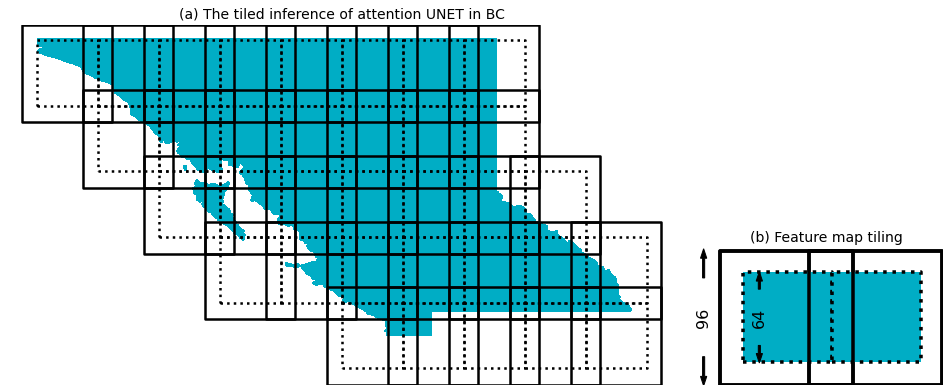

In [12]:
fig = plt.figure(figsize=(13, 5.0))

gs = gridspec.GridSpec(1, 2, width_ratios=[2.5, 1])
ax = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0)

CS = ax.pcolormesh(gridx_BC[bc_e7:-bc_e4, bc_e4:-bc_e8], gridy_BC[bc_e7:-bc_e4, bc_e4:-bc_e8], 
                   pad_BC[80, bc_e7:-bc_e4, bc_e4:-bc_e8, 0], vmin=0.001, vmax=1e4*2999.99, cmap=cmap_terrain)
pad = 15
ylim = [np.min(gridx_BC[bc_e7:-bc_e4, bc_e4:-bc_e8])-pad, np.max(gridx_BC[bc_e7:-bc_e4, bc_e4:-bc_e8])+pad]
xlim = [np.min(gridy_BC[bc_e7:-bc_e4, bc_e4:-bc_e8])-pad, np.max(gridy_BC[bc_e7:-bc_e4, bc_e4:-bc_e8])+pad]

ax.set_xlim(xlim)
ax.set_xlim(ylim)
ax.set_axis_off()

for i in range(7, Ny_BC-4):
    for j in range(4, Nx_BC-8):
        
        if i == 7 and j < 9:
            continue
        if i == 8 and j < 7:
            continue
        if i == 9 and j < 6:
            continue
        if i == 10 and j < 5:
            continue
        
        if i >= 10 and j > 11:
            continue
        if i == 9 and j > 12:
            continue
        
        indy_start = i*size_BC
        indx_start = j*size_BC
        indyc_start = indy_start+edge
        indxc_start = indx_start+edge
        
        box_grid = [indy_start, indy_start+size-1, indx_start, indx_start+size-1]
        _, _, points = ind_to_edge(gridx_BC, gridy_BC, box_grid)
        boxes = PatchCollection([patches.Polygon(points)], facecolor='none', edgecolor='k', linestyle='-', linewidth=2.5, zorder=7)
        ax.add_collection(boxes)
        
        boxc_grid = [indyc_start, indyc_start+size_BC, indxc_start, indxc_start+size_BC]
        _, _, points = ind_to_edge(gridx_BC, gridy_BC, boxc_grid)
        boxes = PatchCollection([patches.Polygon(points)], facecolor='none', edgecolor='k', linestyle=':', linewidth=2.5, zorder=7)
        ax.add_collection(boxes)

ax.text(0.5, 1.05, '(a) The tiled inference of attention UNET in BC', ha='center', va='top', fontsize=14, transform=ax.transAxes)
C_fill = list(cmap_terrain(0))

ax = ax2
ax.set_xlim([-32, 160])
ax.set_ylim([0, 256])
ax.set_axis_off()

for i in range(1):
    for j in range(2):
        
        indy_start = i*size_BC; indx_start = j*size_BC
        indyc_start = indy_start+edge; indxc_start = indx_start+edge
        
        box_grid = [indy_start, indy_start+size-1, indx_start, indx_start+size-1]
        _, _, points = ind_to_edge(gridx_BC, gridy_BC, box_grid)
        boxes = PatchCollection([patches.Polygon(points)], facecolor='none', edgecolor='k', linestyle='-', linewidth=3.5, zorder=1)
        ax.add_collection(boxes)
        
        boxc_grid = [indyc_start, indyc_start+size_BC, indxc_start, indxc_start+size_BC]
        _, _, points = ind_to_edge(gridx_BC, gridy_BC, boxc_grid)
        boxes = PatchCollection([patches.Polygon(points)], edgecolor='k', facecolor=C_fill, linestyle=':', linewidth=3.5, zorder=2)
        ax.add_collection(boxes)
        
        box_grid = [indy_start, indy_start+size-1, indx_start, indx_start+size-1]
        _, _, points = ind_to_edge(gridx_BC, gridy_BC, box_grid)
        boxes = PatchCollection([patches.Polygon(points)], facecolor='none', edgecolor='k', linestyle='-', linewidth=3.5, zorder=3)
        ax.add_collection(boxes)

ax2.text(76, 100, '(b) Feature map tiling', ha='center', va='bottom', fontsize=14)    
ax2.text(-12, 48, '96', fontsize=16, rotation='vertical', ha='center', va='center', zorder=4)        
ax2.arrow(-12, 48+28, 0, 14, width=1.5, fc='k', ec='k', zorder=4)
ax2.arrow(-12, 48-28, 0, -14, width=1.5, fc='k', ec='k', zorder=4)
ax2.text(28, 48, '64', fontsize=16, rotation='vertical', ha='center', va='center', zorder=4)      
ax2.arrow(28, 48+20, 0, 5.75, width=1.5, fc='k', ec='k', zorder=4)
ax2.arrow(28, 48-20, 0, -5.75, width=1.5, fc='k', ec='k', zorder=4)

if need_publish:
    # Save figure
    fig.savefig(fig_dir+'DSCALE_inference.png', format='png', **fig_keys)